In [1]:
import random
import time
import numpy as np

from IPython.display import Audio, display

import sys
# sys.path.append('/mnt/weka/sharath/projects/wsds')
from hume_wsds import WSDataset

In [2]:
# datasets = {
#     'wyndlabs-1M-en': '/mnt/weka/data-wsds/wyndlabs_1M-en/v4-vad_ws_continuous',
# }
# ds_name = "wyndlabs-1M-en"
# ds = WSDataset(datasets[ds_name])

In [3]:
datasets = {
    'wyndlabs-1M-ja': '/mnt/weka/data-wsds/hq_annealed/wyndlabs_1M-ja/v5-diarized_continuous',
}
ds_name = "wyndlabs-1M-ja"
ds = WSDataset(datasets[ds_name])

In [4]:
sample = ds.random_sample()

print("### Available columns:\n")

for k in sample.keys():
    if not k.startswith("dtok") and k != "audio":
        kp = f"`{k}`" if "." in k else k
        try:
            val = sample.__repr_field__(k)
            print(f"{kp} = {val}")
        except FileNotFoundError:
            pass

### Available columns:

__key__ = 'h258duOHY14/h258duOHY14_082'
c50 = 59.8125
dbu = -25.359375
`language_whisper.txt` = 'ja'
pq = 7.34375
probability_whisper = 0.99853515625
snr = 47.9375
`transcription_wslang_continuous.txt` = 'またですねリードレプリカ複数並べていっていわゆるスケールアウトというスケールができますのでトラフィックの拡大にも対応しやすいという面がありますただしですねセレクトを'


In [5]:
print("Number of samples (rows):", ds.index.n_samples)

Number of samples (rows): 1118062


In [6]:
language_codes = {
    # "English": "en",
    # "Mandarin Chinese": "zh", 
    # "Hindi": "hi",  
    # "Spanish": "es", 
    # "French": "fr",  
    # "Indonesian": "id",
    # "Turkish": "tr",
    # "Danish": "da",
    "Japanese": "ja",
}
lang_prob = '0.99'
pq_filter = 6
snr_filter = 20
sr = 16000
save_audio = False
preview_audio= True
N = 1

In [7]:
for lang in language_codes.items():
    lang = lang[1]
    print(f"Creating a selection for language: {lang}")
    # sql_query = f"`language_whisper.txt` == '{lang}' AND `probability_whisper` > {lang_prob} AND `pq` > {pq_filter} AND `music_qual` == 0 AND `snr` > {snr_filter}"
    sql_query = f"`language_whisper.txt` == '{lang}' AND `probability_whisper` > {lang_prob} AND `pq` > {pq_filter} AND `snr` > {snr_filter}"
    
    if save_audio: 
        out_dir = Path(f"query_audio_results/{lang}")
        out_dir.mkdir(parents=True, exist_ok=True)
    
    matches = ds.filtered(sql_query, N=N)
    
    
    for s in matches:
        show_text = s.get_one_of(
            'transcription_wslang_turbo_raw.txt',
            'txt',
            'transcription_wslang_continuous.txt',
        )
        print(f"--- Sample {s['__key__']} ---")
        print(f"Transcript: {show_text}")
        print(f"pq: {s.get('pq')}")
        print(f"snr {s.get('snr')}")
        print(f"language: {s.get('language_whisper.txt')}")
        print(f"lang probability: {s.get('probability_whisper')}")
    
        if "audio" in s and s["audio"].tend - s["audio"].tstart > 0:
            arr = s["audio"].load(sr).numpy()
        
            if arr is None or arr.size == 0:
                continue
        
            arr = np.asarray(arr, dtype=np.float32)
            if preview_audio: 
                display(Audio(arr, rate=sr))
                print("---"* 10)
            if arr.ndim == 2 and arr.shape[0] < arr.shape[1]:
                arr = arr.T 
            if save_audio: 
                print(f"Saving {s['__key__']}")
                
                fname = out_dir / f"{s['__key__'].replace('/', '_')}.wav"
                sf.write(fname, arr, sr, format="WAV", subtype="PCM_16")
                print("---"* 10)


Creating a selection for language: ja
--- Sample oZhCEvjv0Oc/oZhCEvjv0Oc_614 ---
Transcript: 着信表示を見るのさえ嫌な気分で、クッションの下に携帯を仕込んでイルスを使うことにしました。
pq: 7.54296875
snr 62.25
language: ja
lang probability: 0.99853515625


/mnt/weka/sharath/projects/wsds/hume_wsds/ws_audio.py:60: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  reader = torchaudio.io.StreamReader(src=to_filelike(self.src))


------------------------------


[TIMER] speech_duration: 0.00s (4822 rows)
[TIMER] pq: 28.86s (2000002 rows, limit=2000000)
[TIMER] snr: 29.07s (2000002 rows, limit=2000000)
[TIMER] language_whisper.txt: 15.32s (2000001 rows, limit=2000000)
[TIMER] TOTAL time: 73.25s


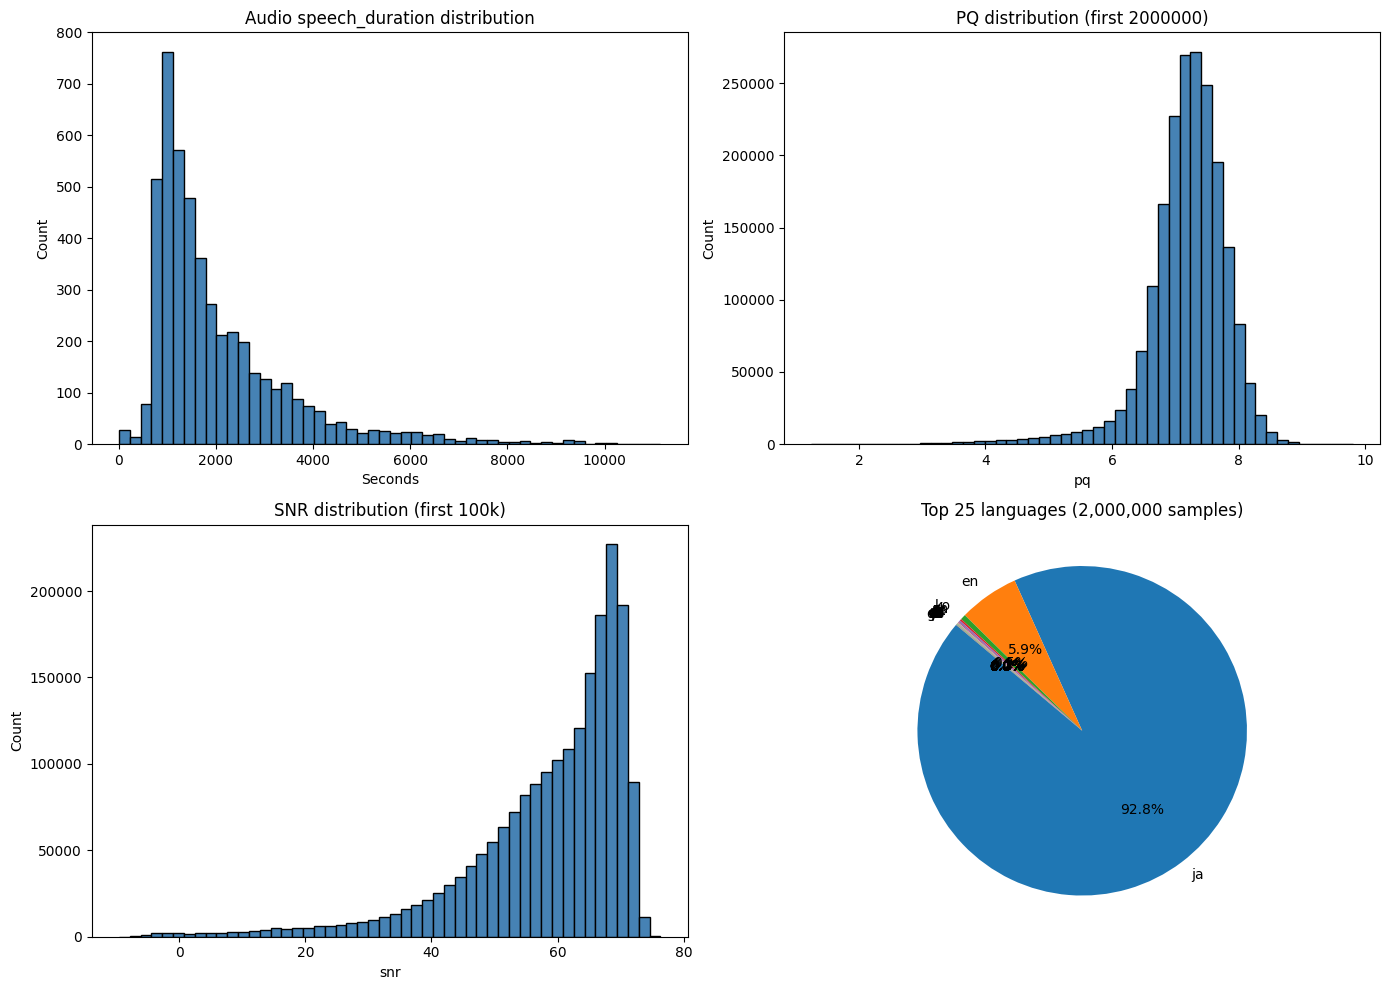

In [8]:
import matplotlib.pyplot as plt
from collections import Counter
import time

t0 = time.time()

t_start = time.time()
rows = ds.index.query("SELECT speech_duration FROM files WHERE speech_duration IS NOT NULL")
durations = [r[0] for r in rows]
print(f"[TIMER] speech_duration: {time.time() - t_start:.2f}s ({len(durations)} rows)")

limit = 2_000_000

t_start = time.time()
pq_vals = []
for i, s in enumerate(ds):
    if "pq" in s and s["pq"] is not None:
        pq_vals.append(float(s["pq"]))
    if i > limit:
        break
print(f"[TIMER] pq: {time.time() - t_start:.2f}s ({len(pq_vals)} rows, limit={limit})")

t_start = time.time()
snr_vals = []
for i, s in enumerate(ds):
    if "snr" in s and s["snr"] is not None:
        snr_vals.append(float(s["snr"]))
    if i > limit:
        break
print(f"[TIMER] snr: {time.time() - t_start:.2f}s ({len(snr_vals)} rows, limit={limit})")

t_start = time.time()
langs = []
for i, s in enumerate(ds):
    if "language_whisper.txt" in s:
        langs.append(s["language_whisper.txt"])
    if i >= limit:
        break
lang_counts = Counter(langs)
labels, sizes = zip(*lang_counts.most_common(25))  # top 25 only
print(f"[TIMER] language_whisper.txt: {time.time() - t_start:.2f}s ({len(langs)} rows, limit={limit})")

print(f"[TIMER] TOTAL time: {time.time() - t0:.2f}s")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(durations, bins=50, color="steelblue", edgecolor="black")
axes[0, 0].set_title("Audio speech_duration distribution")
axes[0, 0].set_xlabel("Seconds")
axes[0, 0].set_ylabel("Count")

axes[0, 1].hist(pq_vals, bins=50, color="steelblue", edgecolor="black")
axes[0, 1].set_title(f"PQ distribution (first {limit})")
axes[0, 1].set_xlabel("pq")
axes[0, 1].set_ylabel("Count")

axes[1, 0].hist(snr_vals, bins=50, color="steelblue", edgecolor="black")
axes[1, 0].set_title("SNR distribution (first 100k)")
axes[1, 0].set_xlabel("snr")
axes[1, 0].set_ylabel("Count")

axes[1, 1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
axes[1, 1].set_title(f"Top {len(labels)} languages ({limit:,} samples)")

plt.tight_layout()
plt.show()

In [269]:
for row in ds.index.query("PRAGMA table_info(files);"):
    print(row)

(0, 'name', 'TEXT', 1, None, 1)
(1, 'shard_id', 'INTEGER', 1, None, 0)
(2, 'offset', 'INTEGER', 1, None, 0)
(3, 'audio_duration', 'REAL', 1, None, 0)
(4, 'speech_duration', 'REAL', 1, None, 0)
